<a href="https://colab.research.google.com/github/IlliaKindratenko/Machine-learning/blob/main/%D0%9B_%D0%A0_4_2_%D0%9A%D1%96%D0%BD%D0%B4%D1%80%D0%B0%D1%82%D0%B5%D0%BD%D0%BA%D0%BE_%D0%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Завдання 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
file_path = '/content/drive/My Drive/titanic files/titanic.csv'

df = pd.read_csv(file_path)

#Виведення перших 5 рядків
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Обробка датасету перед побудовою моделей

In [21]:
# Вибір функції
X = df[['Pclass', 'Age', 'Sex', 'Fare', 'Embarked', 'Survived']].copy()

# Змініть стать на 0 та 1
X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})

# Змініть Embarked до 0, 1 і 2
X['Embarked'] = X['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

X.head()

,Pclass,Age,Sex,Fare,Embarked,Survived
0,3,34.5,0,7.8292,2,0
1,3,47.0,1,7.0000,0,1
2,2,62.0,0,9.6875,2,0
3,3,27.0,0,8.6625,0,0
4,3,22.0,1,12.2875,0,1


In [22]:
# Перевірити відсутні значення
X.isnull().sum()

,0
Pclass,0
Age,86
Sex,0
Fare,1
Embarked,0
Survived,0


In [23]:
# Видалити відсутні значення в Survived і Embarked
X = X.dropna(subset=['Survived', 'Embarked'])

# Заповніть відсутні значення в Age і Fare медіаною
X['Age'] = X['Age'].fillna(X['Age'].median(skipna=True))
X['Fare'] = X['Fare'].fillna(X['Fare'].median(skipna=True))

X = X.apply(pd.to_numeric, errors='coerce')

# Перевірити відсутні значення
X.isnull().sum()

,0
Pclass,0
Age,0
Sex,0
Fare,0
Embarked,0
Survived,0


In [24]:
# Перевірте типи даних
X.dtypes

,0
Pclass,int64
Age,float64
Sex,int64
Fare,float64
Embarked,int64
Survived,int64


In [25]:
# Зведена статистика
print('Dataset shape:', X.shape)
X.describe()

Dataset shape: (418, 6)


,Pclass,Age,Sex,Fare,Embarked,Survived
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,29.599282,0.363636,35.576535,0.464115,0.363636
std,0.841838,12.703770,0.481622,55.850103,0.685516,0.481622
min,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,23.000000,0.000000,7.895800,0.000000,0.000000
50%,3.000000,27.000000,0.000000,14.454200,0.000000,0.000000
75%,3.000000,35.750000,1.000000,31.471875,1.000000,1.000000
max,3.000000,76.000000,1.000000,512.329200,2.000000,1.000000


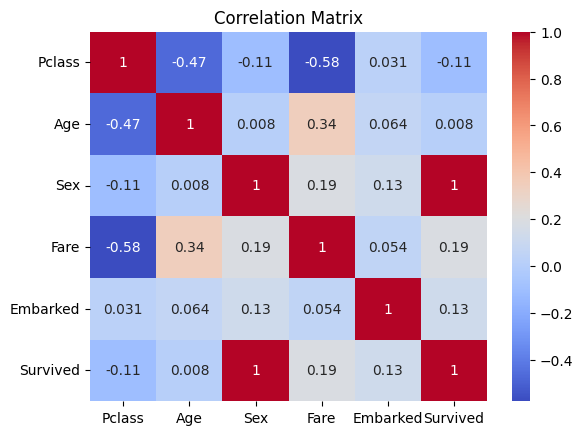

In [26]:
# Кореляційна матриця
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

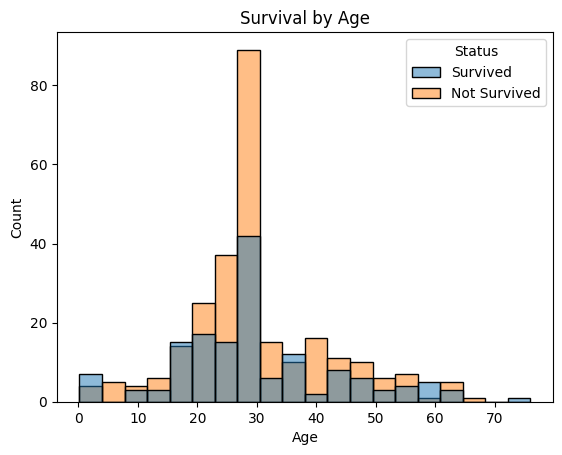

In [27]:
df_survived = X.loc[X['Survived'] == 1, ['Age']].copy()
df_survived['Status'] = 'Survived'

df_not_survived = X.loc[X['Survived'] == 0, ['Age']].copy()
df_not_survived['Status'] = 'Not Survived'

df_combined = pd.concat([df_survived, df_not_survived])

# Побудуйте гістограму з відтінком
sns.histplot(data=df_combined, x='Age', hue='Status', bins=20)
plt.title('Survival by Age')
plt.show()

Пік загиблих 25-31 рік. Найвищі шанси вижити є у дітей 0-5 років та літніх людей 57-61 рік.

Маючи дані будуємо моделі

In [28]:
# Розділіть дані на функції та ціль
y = X['Survived']
X_features = X.copy().drop(columns=['Survived'])

# Розділіть дані на навчальні та тестові набори
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Стандартизуйте функції
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Створити словник класифікаторів
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVC': SVC(),
}

In [31]:
# Створити словник гіперпараметрів
params = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': [None, 'l2'],
        },
    'Decision Tree': {
        'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],
        'min_samples_split': [2, 4, 6, 8, 10, 20, 40],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32]
        },
    'SVC': {
        'C': [0.1, 1, 10],
        'gamma': [0.1, 0.01],
        'kernel': ['rbf']
        }
}

In [33]:
# Тренуванти моделі
best_models = {}
for key, classifier in classifiers.items():
    grid = GridSearchCV(classifier, params[key], cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[key] = grid.best_estimator_
    print(f'{key} best parameters: {grid.best_params_}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Logistic Regression best parameters: {'C': 0.001, 'penalty': None}
Decision Tree best parameters: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
SVC best parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}


In [34]:
# Оцініть моделі
for key, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f'{key} accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'{key} confusion matrix:\n{confusion_matrix(y_test, y_pred)}')
    print(f'{key} classification report:\n{classification_report(y_test, y_pred)}')
    print('--------------------------------------------------')

Logistic Regression accuracy: 1.0
Logistic Regression confusion matrix:
[[50  0]
 [ 0 34]]
Logistic Regression classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

--------------------------------------------------
Decision Tree accuracy: 1.0
Decision Tree confusion matrix:
[[50  0]
 [ 0 34]]
Decision Tree classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

---------------------------------------------

Всі моделі мають однаковий результат точності у 100%

In [35]:
random_indices = np.random.choice(X_test.shape[0], 10, replace=False)
X_sample = X_test[random_indices]
y_sample = y_test.iloc[random_indices]

y_sample_pred = best_models['Decision Tree'].predict(X_sample)

# Створіть фрейм даних порівняння
comparison_df = pd.DataFrame({
    'Sample Index': random_indices,
    'Actual': y_sample,
    'Predicted': y_sample_pred
})

comparison_df

,Sample Index,Actual,Predicted
165,78,1,1
331,68,0,0
113,25,1,1
148,27,0,0
82,7,0,0
110,42,0,0
396,59,0,0
412,16,1,1
17,82,0,0
406,19,0,0
